In [152]:
import random
import numpy as np
import tensorflow as tf

# Set the random seeds
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [153]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install geopandas
!pip install simpletransformers
!pip install transformers

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime as dt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler,MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
# ! pip install plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Preprocess

In [437]:
#import dataset
stock = pd.read_csv('drive/Shareddrives/519/dataset/stock.csv')

# Rename columns
stock.rename(columns={"Date":"date","Open":"open","High":"high","Low":"low","Close":"close"}, inplace= True)

In [438]:
#import dataset
gdp = pd.read_csv('drive/Shareddrives/519/dataset/GDP.csv')

### Check null value

In [439]:
stock.isnull().sum()

date         0
open         1
high         1
low          1
close        1
Adj Close    1
Volume       1
dtype: int64

### Drop null value

In [440]:
stock.dropna(inplace=True)
stock.isna().any()

date         False
open         False
high         False
low          False
close        False
Adj Close    False
Volume       False
dtype: bool

### Check the dtypes of each variable

In [383]:
# Check the dtypes of each variable
print(stock.dtypes)
stock.head

date          object
open         float64
high         float64
low          float64
close        float64
Adj Close    float64
Volume       float64
dtype: object


<bound method NDFrame.head of            date         open         high          low        close  \
0    2020-08-19  2141.000000  2154.000000  2121.350098  2131.550049   
1    2020-08-20  2120.000000  2123.899902  2088.000000  2097.050049   
2    2020-08-21  2118.000000  2122.000000  2077.000000  2081.850098   
3    2020-08-24  2091.399902  2104.500000  2070.500000  2095.750000   
4    2020-08-25  2106.000000  2111.300049  2078.000000  2082.100098   
..          ...          ...          ...          ...          ...   
245  2021-08-12  2124.899902  2126.199951  2105.000000  2110.500000   
246  2021-08-13  2117.300049  2149.899902  2108.949951  2145.649902   
247  2021-08-16  2149.350098  2203.000000  2128.149902  2173.500000   
248  2021-08-17  2168.850098  2185.199951  2147.850098  2164.250000   
249  2021-08-18  2174.000000  2186.800049  2152.600098  2172.649902   

       Adj Close      Volume  
0    2124.715088  15731396.0  
1    2090.325684  10401212.0  
2    2075.174316  116671

In [441]:
# Change the date variable to datetime variable
stock['date'] = pd.to_datetime(stock['date'])

# EDA

### Duration of the dataset

In [385]:
print("Starting date: ",stock.iloc[0][0])
print("Ending date: ", stock.iloc[-1][0])
print("Duration: ", stock.iloc[-1][0]-stock.iloc[0][0])

Starting date:  2020-08-19 00:00:00
Ending date:  2021-08-18 00:00:00
Duration:  364 days 00:00:00


### Monthwise comparision between Stock actual, open and close price

In [163]:
monthvise= stock.groupby(stock['date'].dt.strftime('%B'))[['open','close']].mean().sort_values(by='close')
monthvise.head()

,open,close
date,,
January,1968.000006,1957.662494
April,1963.384207,1961.278956
November,1985.213160,1964.847367
May,1967.050006,1972.582513
December,1980.765897,1978.338645


In [164]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock actual, open and close price')
fig.show()

### Monthwise High and Low stock price

In [165]:
stock.groupby(stock['date'].dt.strftime('%B'))['low'].min()

date
April        1876.699951
August       2041.150024
December     1855.250000
February     1848.000000
January      1830.000000
July         2016.250000
June         2081.000000
March        1973.699951
May          1906.000000
November     1835.099976
October      1991.000000
September    2044.250000
Name: low, dtype: float64

In [166]:
monthvise_high= stock.groupby(stock['date'].dt.strftime('%B'))['high'].max()
monthvise_low= stock.groupby(stock['date'].dt.strftime('%B'))['low'].min()

In [167]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

### Trend comparision between stock price, open price, close price, high price, low price

In [168]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(stock, x=stock.date, y=[stock['open'], stock['close'], 
                                          stock['high'], stock['low']],
             labels={'date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Close price prediction preparation and preprocessing

### Make separate dataframe for close price

In [442]:
closedf =stock[['date','close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (249, 2)


### Plotting stock close price chart¶

In [170]:
fig = px.line(closedf, x=closedf.date, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='Stock close price chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

### Normalizing / scaling close value between 0 to 1

In [387]:
close_stock = closedf.copy()
del closedf['date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(249, 1)


### Split data for training and testing

In [377]:
training_size=int(len(closedf)*0.65)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size],closedf[training_size:len(closedf)]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (161, 1)
test_data:  (88, 1)


### Create new dataset according to requirement of time-series prediction

In [388]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [389]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (145, 15)
y_train:  (145,)
X_test:  (72, 15)
y_test (72,)


# Model Construction

## KNN(BASELINE)

In [175]:
from sklearn import neighbors

K = time_step
neighbor = neighbors.KNeighborsRegressor(n_neighbors = K)
neighbor.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=20)

In [176]:
# Lets Do the prediction 

train_predict=neighbor.predict(X_train)
test_predict=neighbor.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (140, 1)
Test data prediction: (67, 1)


In [177]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

### Evaluation 
**RMSE, MSE and MAE**
Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.

In [178]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  54.93784460760559
Train data MSE:  3018.1667701294186
Train data MAE:  42.44030576392857
-------------------------------------------------------------------------------------
Test data RMSE:  73.64352996681602
Test data MSE:  5423.369505973328
Test data MAE:  59.36032983731346


**Explained variance regression score**

The explained variance score explains the dispersion of errors of a given dataset, and the formula is written as follows: Here, and Var(y) is the variance of prediction errors and actual values respectively. Scores close to 1.0 are highly desired, indicating better squares of standard deviations of errors.

In [179]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.7620835670107005
Test data explained variance regression score: 0.4696714202715382


**R2 score**

R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.

1 = Best 

0 or < 0 = worse

In [180]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.7546657954595464
Test data R2 score: 0.11254453080637394


**MGD,MPD**

In [181]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.0006997221613948573
Test data MGD:  0.0012466701879108133
----------------------------------------------------------------------
Train data MPD:  1.4513763032324472
Test data MPD:  2.599241869095369


### Comparision 
**between original stock close price vs predicted close price**

In [182]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (249, 1)
Test predicted data:  (249, 1)


### Prediction
**Predicting next 10 days**

In [183]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = neighbor.predict(x_input)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = neighbor.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
        
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


**Plotting last 15 days and next predicted 10 days**

In [184]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[21 22 23 24 25 26 27 28 29 30]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 20 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

**Plotting whole closing stock price with prediction**

In [186]:
knndf=closedf.tolist()
knndf.extend((np.array(lst_output).reshape(-1,1)).tolist())
knndf=scaler.inverse_transform(knndf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(knndf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

## LSTM
**rebuild from Kaggle**

In [187]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [188]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [189]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 20, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=5,verbose=1)

In [191]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

3/3 [==============================] - 0s 5ms/step


((140, 1), (67, 1))

In [192]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

### Evaluation 
**RMSE, MSE and MAE**

Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.

In [193]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  28.269482407408173
Train data MSE:  799.1636355827602
Train data MAE:  22.6749398249442
-------------------------------------------------------------------------------------
Test data RMSE:  43.47915054315719
Test data MSE:  1890.4365319545261
Test data MAE:  35.86252329524255


**variance regression score**

The explained variance score explains the dispersion of errors of a given dataset, and the formula is written as follows: Here, and Var(y) is the variance of prediction errors and actual values respectively. Scores close to 1.0 are highly desired, indicating better squares of standard deviations of errors.

In [194]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9383270099457424
Test data explained variance regression score: 0.6990692032423325


**R2 score**
R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.

1 = Best \\

0 or < 0 = worse

In [195]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9350393169874618
Test data R2 score: 0.6906575814908662


**MGD,MPD**
Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)

In [196]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.00018853625210907117
Test data MGD:  0.00042464368472883813
----------------------------------------------------------------------
Train data MPD:  0.38757725982405383
Test data MPD:  0.8953833696655306


### Comparision 
**between original stock close price vs predicted close price**

In [197]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (249, 1)
Test predicted data:  (249, 1)


### Prediction
**Predicting next 10 days**

In [198]:
x_input

array([[0.54247823, 0.60567756, 0.51201833, 0.48735993, 0.50994622,
        0.57055541, 0.55646497, 0.6292994 , 0.68700784, 0.66784083,
        0.68524634, 0.58929758, 0.58929758, 0.58135104, 0.58135104,
        0.55072009, 0.5320452 , 0.47780773, 0.45958872, 0.44034399]])

In [199]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)

In [200]:
x_input

array([[0.57760038, 0.54651875, 0.48673871, 0.44146292, 0.40489015,
        0.43783673, 0.40064248, 0.47772483, 0.50932449, 0.54247823,
        0.60567756, 0.51201833, 0.48735993, 0.50994622, 0.57055541,
        0.55646497, 0.6292994 , 0.68700784, 0.66784083, 0.68524634]])

In [201]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


**Plotting last 15 days and next predicted 10 days**

In [202]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[21 22 23 24 25 26 27 28 29 30]


In [203]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

**Plotting whole closing stock price with prediction¶**

In [204]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

## CNN+LSTM

In [461]:
# X_train, y_train = create_dataset(train_data, time_step)
# X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (145, 15)
y_train:  (145,)
X_test:  (72, 15)
y_test (72,)


In [462]:
train_X = np.array(X_train)
test_X = np.array(X_test)
# train_Y = np.array(y_train)
# test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,time_step,1)
test_X = test_X.reshape(test_X.shape[0],1,time_step,1)

In [392]:
X_train.shape

(145, 15)

In [393]:
train_X.shape

(145, 1, 15, 1)

In [463]:
# For creating model and training
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError
CLmodel = tf.keras.Sequential()

# Creating the Neural Network model here...
# CNN layers
CLmodel.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, time_step, 1))))
# model.add(TimeDistributed(MaxPooling1D(2)))
CLmodel.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
# model.add(TimeDistributed(MaxPooling1D(2)))
# model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
# model.add(TimeDistributed(MaxPooling1D(2)))
CLmodel.add(TimeDistributed(Flatten()))
# model.add(Dense(5, kernel_regularizer=L2(0.01)))

# LSTM layers
CLmodel.add(Bidirectional(LSTM(time_step, return_sequences=True)))
CLmodel.add(Dropout(0.5))
CLmodel.add(Bidirectional(LSTM(time_step, return_sequences=False)))
CLmodel.add(Dropout(0.5))

# model.add(LSTM(32,return_sequences=True,input_shape=(time_step,1)))
# model.add(LSTM(32,return_sequences=True))
# model.add(LSTM(32))
# model.add(Dense(1))


#Final layers
CLmodel.add(Dense(1, activation='linear'))
CLmodel.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

history = CLmodel.fit(train_X, y_train, validation_data=(test_X,y_test), epochs=100,batch_size=10, verbose=1, shuffle =True)

Epoch 1/100
15/15 [==============================] - 25s 170ms/step - loss: 0.1792 - mse: 0.1792 - mae: 0.3517 - val_loss: 0.0315 - val_mse: 0.0315 - val_mae: 0.1317
Epoch 2/100
15/15 [==============================] - 0s 24ms/step - loss: 0.0692 - mse: 0.0692 - mae: 0.2145 - val_loss: 0.0373 - val_mse: 0.0373 - val_mae: 0.1472
Epoch 3/100
15/15 [==============================] - 0s 24ms/step - loss: 0.0804 - mse: 0.0804 - mae: 0.2147 - val_loss: 0.0235 - val_mse: 0.0235 - val_mae: 0.1133
Epoch 4/100
15/15 [==============================] - 0s 23ms/step - loss: 0.0619 - mse: 0.0619 - mae: 0.1933 - val_loss: 0.0310 - val_mse: 0.0310 - val_mae: 0.1319
Epoch 5/100
15/15 [==============================] - 0s 22ms/step - loss: 0.0526 - mse: 0.0526 - mae: 0.1780 - val_loss: 0.0211 - val_mse: 0.0211 - val_mae: 0.1061
Epoch 6/100
15/15 [==============================] - 0s 23ms/step - loss: 0.0407 - mse: 0.0407 - mae: 0.1537 - val_loss: 0.0228 - val_mse: 0.0228 - val_mae: 0.1111
Epoch 7/100
15

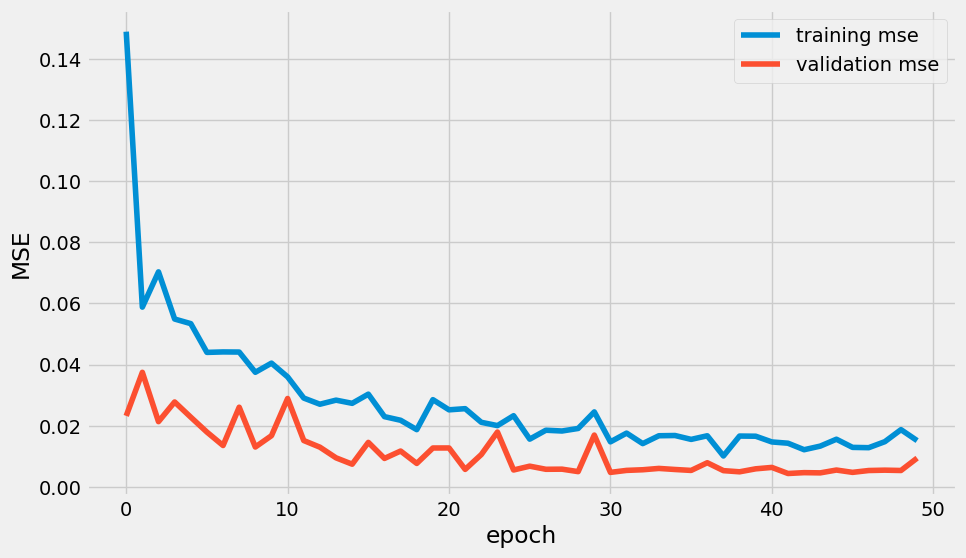

In [405]:
plt.plot(history.history['mse'], label='training mse')
plt.plot(history.history['val_mse'], label='validation mse')
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.legend()

### Evaluation

In [464]:
CLmodel.evaluate(test_X, y_test)

3/3 [==============================] - 0s 8ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0601


[0.006697855424135923, 0.006697855424135923, 0.060114536434412]

In [465]:
from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

# predict probabilities for test set
yhat_probs = CLmodel.predict(test_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

var = explained_variance_score(y_test.reshape(-1,1), yhat_probs)
print('Variance: %f' % var)

r2 = r2_score(y_test.reshape(-1,1), yhat_probs)
print('R2 Score: %f' % var)

var2 = max_error(y_test.reshape(-1,1), yhat_probs)
print('Max Error: %f' % var2)

Variance: 0.845244
R2 Score: 0.845244
Max Error: 0.308800


3/3 [==============================] - 0s 8ms/step


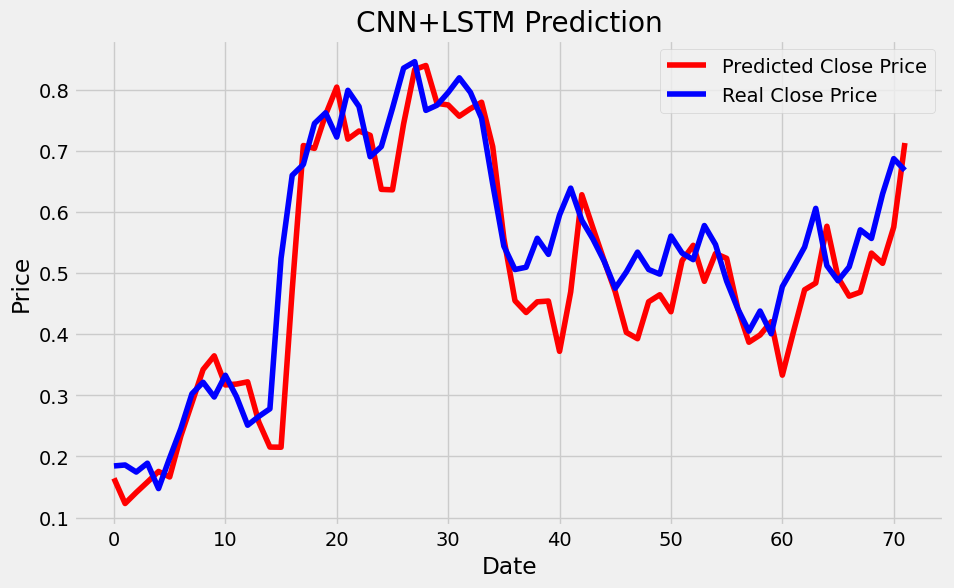

In [466]:
pred  = CLmodel.predict(test_X)
# test_label = y_test.reshape(-1,1)
# predicted = np.array(pred[:,0]).reshape(-1,1)
# len_t = len(train_X)
# for j in range(len_t , len_t + len(test_X)):
#     temp = data.iloc[j,3]
#     test_label[j - len_t] = test_label[j - len_t] * temp + temp
#     predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(pred, color = 'red', label = 'Predicted Close Price')
plt.plot(y_test, color = 'blue', label = 'Real Close Price')
plt.title('CNN+LSTM Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## LSTM+sentiment score

### Add sentiment score to each stock trading day

#### Preprocess the text data

In [252]:
# Download India news dataset 
india_news = pd.read_csv('drive/Shareddrives/519/dataset/india-news-headlines.csv')
india_news['publish_date'] = pd.to_datetime(india_news['publish_date'], format='%Y%m%d')

In [253]:
india_news

,publish_date,headline_category,headline_text
0,2001-01-02,unknown,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,unknown,Fissures in Hurriyat over Pak visit
2,2001-01-02,unknown,America's unwanted heading for India?
3,2001-01-02,unknown,For bigwigs; it is destination Goa
4,2001-01-02,unknown,Extra buses to clear tourist traffic
...,...,...,...
3650965,2022-03-31,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
3650966,2022-03-31,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650967,2022-03-31,city.trichy,As Covid-19 cases drop to nil in southern dist...
3650968,2022-03-31,city.erode,Tamil Nadu sees marginal rise of Covid cases w...


In [254]:
# Filter the news between Aug 2020 - Aug 2021
india_news = india_news[india_news['publish_date'] > '2020-08-18']
india_news = india_news[india_news['publish_date'] < '2021-08-19'].reset_index(drop = True)
india_news

,publish_date,headline_category,headline_text
0,2020-08-19,city.surat,Rough diamond import decline 82% in April-July...
1,2020-08-19,city.kolhapur,Chikali; Ambewadi residents leave as Panchagan...
2,2020-08-19,city.ahmedabad,SC dismisses state govt's appeal
3,2020-08-19,entertainment.kannada.movies.news,Prem gets nostalgic about his Shivarajkumar fi...
4,2020-08-19,life-style.spotlight,Drive-in theatres looking to capitalise in pos...
...,...,...,...
182044,2021-08-18,city.goa,FSDL acquires media rights for AFC competitions
182045,2021-08-18,city.goa,Need passionate people for sports to succeed; ...
182046,2021-08-18,city.delhi,No end in sight to waste problem; East Delhi M...
182047,2021-08-18,city.delhi,Quality education; health taking Delhi on US g...


In [239]:
# Import nltk for text preprocessing
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [261]:
# Preprocess text data
from nltk.corpus import stopwords
from string import punctuation

def remove_stopwords_and_punctuations(tokens):
    # Convert stopwords set to lowercase
    stop_words = set(stopwords.words('english'))
    
    # Filter out stopwords and punctuations
    filtered_tokens = [token.lower() for token in tokens if token.lower() not in stop_words and token not in punctuation]
    
    return filtered_tokens

# Tokenize the text column
india_news['tokenized_text'] = india_news['headline_text'].apply(nltk.word_tokenize)

# Remove stopwords and punctuations
india_news['tokenized_text'] = india_news['tokenized_text'].apply(remove_stopwords_and_punctuations)


In [262]:
india_news.head

<bound method NDFrame.head of        publish_date                  headline_category  \
0        2020-08-19                         city.surat   
1        2020-08-19                      city.kolhapur   
2        2020-08-19                     city.ahmedabad   
3        2020-08-19  entertainment.kannada.movies.news   
4        2020-08-19               life-style.spotlight   
...             ...                                ...   
182044   2021-08-18                           city.goa   
182045   2021-08-18                           city.goa   
182046   2021-08-18                         city.delhi   
182047   2021-08-18                         city.delhi   
182048   2021-08-18            business.india-business   

                                            headline_text  \
0       Rough diamond import decline 82% in April-July...   
1       Chikali; Ambewadi residents leave as Panchagan...   
2                        SC dismisses state govt's appeal   
3       Prem gets nostalgic a

### FinBERT

In [308]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
# Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the fine-tuned FinBERT model and tokenizer
model_path = "ProsusAI/finbert"
tokenizer_path = "ProsusAI/finbert"

model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [336]:
def get_sentiment_scores(tokenized_texts):
    texts = [' '.join(tokens) for tokens in tokenized_texts]
    inputs = tokenizer([text[0] for text in texts], padding=True, truncation=True, return_tensors="pt")
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # Get the predicted sentiment score
    outputs = model(**inputs)
    
    # Calculate probabilities from logits
    probabilities = torch.softmax(outputs.logits, dim=-1).detach().cpu().numpy()  # Add the detach() method here
    # scores = torch.softmax(outputs.logits, dim=1).detach().cpu().numpy()
    # print(scores)
    
    # Use the positive class probability as the continuous sentiment score
    sentiment_scores = probabilities[:, 1]

    
    # Return the sentiment score
    # return {"positive": scores[:,1], "negative": scores[:,0]}


    
    # # Normalize the sentiment scores to the range [-1, 1]
    # sentiment_scores = 2 * sentiment_scores - 1
    
    return sentiment_scores

# Process the tokenized texts in batches
batch_size = 64
n_batches = int(np.ceil(len(india_news) / batch_size))
sentiment_scores = []

for i in range(n_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    
    batch_tokenized_texts = india_news['tokenized_text'][start_idx:end_idx].tolist()
    batch_sentiment_scores = get_sentiment_scores(batch_tokenized_texts)
    sentiment_scores.extend(batch_sentiment_scores)

In [337]:
# Add the sentiment scores to the DataFrame
india_news['sentiment_score'] = sentiment_scores

### END

#### Use DistilBERT base uncased finetuned SST-2 model for sentiment score calculation

In [221]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [222]:
!pip install torch torchvision -f https://download.pytorch.org/whl/cu111/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu111/torch_stable.html


In [223]:
# Calculate Sentiment Score
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import Pre-trained model
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)

def get_sentiment_scores(tokenized_texts):
    texts = [' '.join(tokens) for tokens in tokenized_texts]
    
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    outputs = model(**inputs)
    
    # Calculate probabilities from logits
    probabilities = torch.softmax(outputs.logits, dim=-1).detach().cpu().numpy()  # Add the detach() method here
    
    # Use the positive class probability as the continuous sentiment score
    sentiment_scores = probabilities[:, 1]
    
    # Normalize the sentiment scores to the range [-1, 1]
    sentiment_scores = 2 * sentiment_scores - 1
    
    return sentiment_scores

# Process the tokenized texts in batches
batch_size = 64
n_batches = int(np.ceil(len(india_news) / batch_size))
sentiment_scores = []

for i in range(n_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    
    batch_tokenized_texts = india_news['tokenized_text'][start_idx:end_idx].tolist()
    batch_sentiment_scores = get_sentiment_scores(batch_tokenized_texts)
    sentiment_scores.extend(batch_sentiment_scores)

# Add the sentiment scores to the DataFrame
india_news['sentiment_score'] = sentiment_scores

In [339]:
india_news.head(5)

,publish_date,headline_category,headline_text,tokenized_text,sentiment_score
0,2020-08-19,city.surat,Rough diamond import decline 82% in April-July...,"[rough, diamond, import, decline, 82, april-ju...",0.041079
1,2020-08-19,city.kolhapur,Chikali; Ambewadi residents leave as Panchagan...,"[chikali, ambewadi, residents, leave, panchaga...",0.042846
2,2020-08-19,city.ahmedabad,SC dismisses state govt's appeal,"[sc, dismisses, state, govt, 's, appeal]",0.045481
3,2020-08-19,entertainment.kannada.movies.news,Prem gets nostalgic about his Shivarajkumar fi...,"[prem, gets, nostalgic, shivarajkumar, film, j...",0.081602
4,2020-08-19,life-style.spotlight,Drive-in theatres looking to capitalise in pos...,"[drive-in, theatres, looking, capitalise, post...",0.057718


#### Get the average sentiment score for each stock trading day

In [338]:
# Group by the 'date' column and calculate the mean sentiment score for each day
daily_sentiment = india_news.groupby('publish_date')['sentiment_score'].mean().reset_index()

sent_scaler = MinMaxScaler(feature_range=(0, 1))

# Rename the columns for clarity
daily_sentiment.columns = ['publish_date', 'average_sentiment_score']
daily_sentiment['average_sentiment_score'] = sent_scaler.fit_transform(daily_sentiment[['average_sentiment_score']])

No_moving = daily_sentiment.copy(deep=True)

# Transform it into Moving average
window_size = 5
daily_sentiment['average_sentiment_score'] = daily_sentiment['average_sentiment_score'].rolling(window=window_size).mean()
# Drop the first four rows
daily_sentiment = daily_sentiment.iloc[4:]

# Reset the index
daily_sentiment.reset_index(drop=True, inplace=True)

daily_sentiment.head(5)

,publish_date,average_sentiment_score
0,2020-08-23,0.628989
1,2020-08-24,0.731746
2,2020-08-25,0.702213
3,2020-08-26,0.694857
4,2020-08-27,0.677882


#### Add sentiment score to the stock price dataset based on date

In [340]:
stock_sent_df = pd.merge(stock,daily_sentiment, left_on = 'date', right_on = 'publish_date')[['date','close','average_sentiment_score']]
stock_sent_No_moving_df = pd.merge(stock,No_moving, left_on = 'date', right_on = 'publish_date')[['date','close','average_sentiment_score']]

In [341]:
stock_sent_df

,date,close,average_sentiment_score
0,2020-08-24,2095.750000,0.731746
1,2020-08-25,2082.100098,0.702213
2,2020-08-26,2137.300049,0.694857
3,2020-08-27,2110.600098,0.677882
4,2020-08-28,2116.149902,0.625840
...,...,...,...
241,2021-08-12,2110.500000,0.502228
242,2021-08-13,2145.649902,0.533826
243,2021-08-16,2173.500000,0.462661
244,2021-08-17,2164.250000,0.475175


In [342]:
total_stock = stock_sent_df.copy(deep=True)
total_no_moving = stock_sent_No_moving_df.copy(deep=True)

stock_sent_df = stock_sent_df[['close','average_sentiment_score']]
stock_sent_df.head(5)

,close,average_sentiment_score
0,2095.750000,0.731746
1,2082.100098,0.702213
2,2137.300049,0.694857
3,2110.600098,0.677882
4,2116.149902,0.625840


In [343]:
total_scaler = MinMaxScaler(feature_range=(0, 1))
total_stock['close'] = total_scaler.fit_transform(total_stock[['close']])

total_scaler_no_moving = MinMaxScaler(feature_range=(0, 1))
total_no_moving['close'] = total_scaler_no_moving.fit_transform(total_no_moving[['close']])

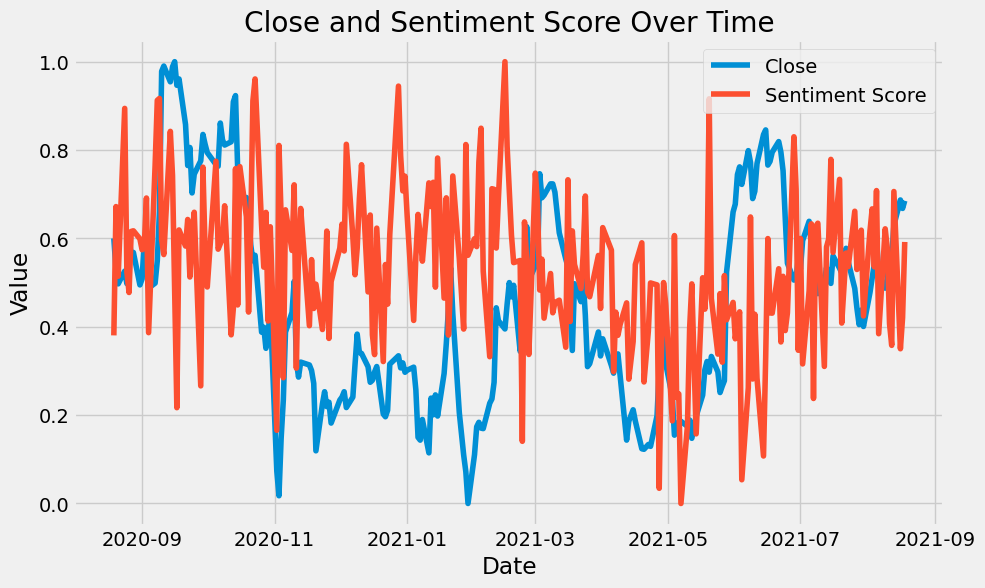

In [344]:
import matplotlib.pyplot as plt

# Create a line chart
plt.figure(figsize=(10, 6))
plt.plot(total_no_moving['date'], total_no_moving['close'], label='Close')
plt.plot(total_no_moving['date'], total_no_moving['average_sentiment_score'], label='Sentiment Score')

# Customize the chart
plt.title('Close and Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='best')

# Display the chart
plt.show()


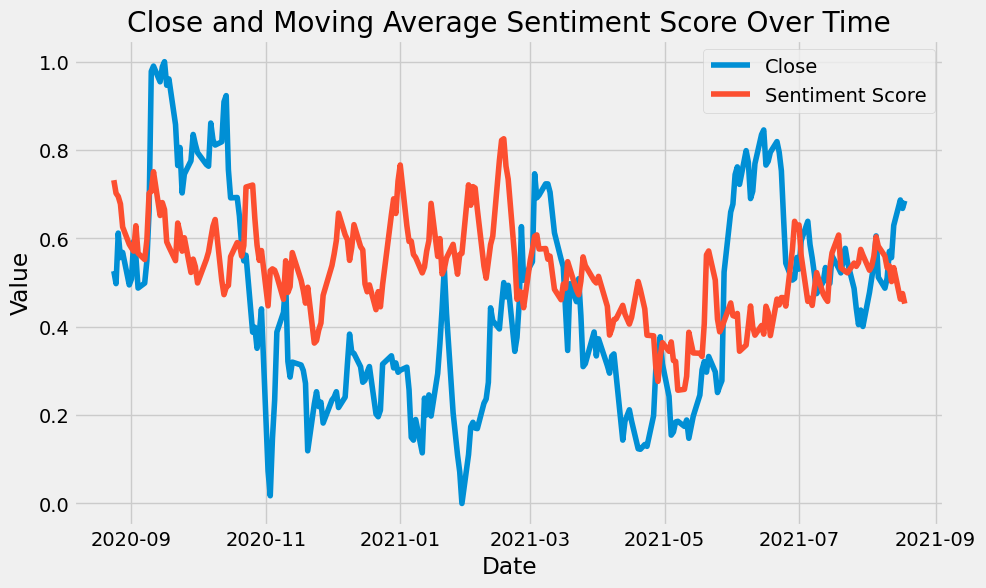

In [345]:
import matplotlib.pyplot as plt

# Create a line chart
plt.figure(figsize=(10, 6))
plt.plot(total_stock['date'], total_stock['close'], label='Close')
plt.plot(total_stock['date'], total_stock['average_sentiment_score'], label='Sentiment Score')

# Customize the chart
plt.title('Close and Moving Average Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='best')

# Display the chart
plt.show()


### Train a new LSTM model with the sentiment score calculated

#### Normalize the data

In [467]:
training_size=int(len(stock_sent_df)*0.65)
test_size=len(stock_sent_df)-training_size

train_data = stock_sent_df[0:training_size].copy(deep=True)
test_data = stock_sent_df[training_size:len(stock_sent_df)].copy(deep=True)

close_scaler = MinMaxScaler(feature_range=(0, 1))
train_data['close'] = close_scaler.fit_transform(train_data[['close']])
test_data['close'] = close_scaler.transform(test_data[['close']])

print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (159, 2)
test_data:  (87, 2)


#### Obtain and Split the Training and Test dataset

In [468]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step),0]  ###i=0, 0,1,2,3-----99   100 
        # pd.concat([a,pd.Series([dataset.iloc[i+time_step-1,1]])])
        a = a.append(pd.Series([dataset.iloc[i+time_step-1,1]]))
        # print(dataset.iloc[i+time_step-1,1])
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step,0])
    return np.array(dataX), np.array(dataY)

In [469]:
# warnings.filterwarnings('ignore')

time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (143, 16)
y_train:  (143,)
X_test:  (71, 16)
y_test (71,)


In [470]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

#### Hyperparameter Tuning

In [236]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [237]:
# Using RandomizedGridSearchCV to find the best set of hyperparameters
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def create_model(lstm_size=96, dropout_rate=0.3):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(LSTM(lstm_size, return_sequences=True, input_shape=(time_step+1, 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_size, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_size))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

param_grid = {
    'model__lstm_size': [32, 64, 96, 128],
    'model__dropout_rate': [0.2, 0.3, 0.4, 0.5]
}

model = KerasRegressor(model=create_model, epochs=70, batch_size=5, verbose=0)

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train, validation_data=(X_test, y_test))

print("Best parameters found: ", grid_result.best_params_)


KeyboardInterrupt: ignored

#### Model Training with the selected hyperparameters

In [471]:
tf.keras.backend.clear_session()
LSmodel = Sequential()
LSmodel.add(LSTM(128, return_sequences=True, input_shape=(time_step+1, 1)))
LSmodel.add(Dropout(0.5))
LSmodel.add(LSTM(128, return_sequences=True))
LSmodel.add(Dropout(0.5))
LSmodel.add(LSTM(128))
LSmodel.add(Dropout(0.5))
LSmodel.add(Dense(1))
LSmodel.compile(loss='mean_squared_error', optimizer='adam')


In [472]:
LSmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 16, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 16, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 16, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [473]:
history = LSmodel.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=250,batch_size=5,verbose=1)

Epoch 1/250
29/29 [==============================] - 7s 49ms/step - loss: 0.0614 - val_loss: 0.0209
Epoch 2/250
29/29 [==============================] - 0s 16ms/step - loss: 0.0306 - val_loss: 0.0311
Epoch 3/250
29/29 [==============================] - 1s 19ms/step - loss: 0.0288 - val_loss: 0.0166
Epoch 4/250
29/29 [==============================] - 0s 17ms/step - loss: 0.0326 - val_loss: 0.0148
Epoch 5/250
29/29 [==============================] - 0s 17ms/step - loss: 0.0321 - val_loss: 0.0138
Epoch 6/250
29/29 [==============================] - 1s 19ms/step - loss: 0.0203 - val_loss: 0.0162
Epoch 7/250
29/29 [==============================] - 0s 17ms/step - loss: 0.0258 - val_loss: 0.0258
Epoch 8/250
29/29 [==============================] - 0s 16ms/step - loss: 0.0264 - val_loss: 0.0153
Epoch 9/250
29/29 [==============================] - 0s 16ms/step - loss: 0.0284 - val_loss: 0.0276
Epoch 10/250
29/29 [==============================] - 1s 19ms/step - loss: 0.0239 - val_loss: 0.0101

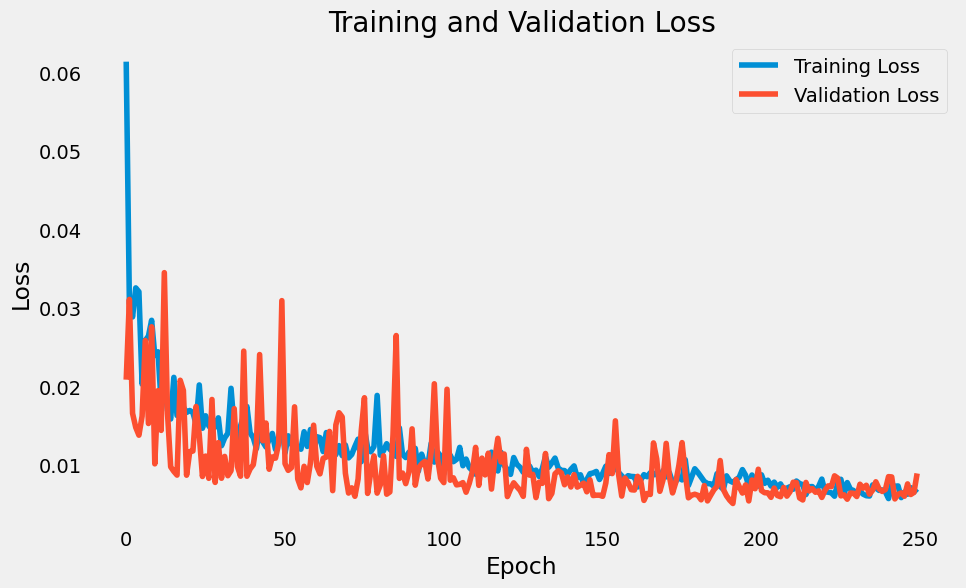

In [474]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Customize the chart
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid()

# Display the chart
plt.show()


In [370]:
### Lets Do the prediction and check performance metrics
train_predict=LSmodel.predict(X_train)
test_predict=LSmodel.predict(X_test)
train_predict.shape, test_predict.shape

3/3 [==============================] - 0s 8ms/step


((143, 1), (71, 1))

In [371]:
# Transform back to original form

train_predict = close_scaler.inverse_transform(train_predict)
test_predict = close_scaler.inverse_transform(test_predict)
original_ytrain = close_scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = close_scaler.inverse_transform(y_test.reshape(-1,1))

### Evaluation 
**RMSE, MSE and MAE**

Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.

In [372]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  37.55755330481497
Train data MSE:  1410.5698102440176
Train data MAE:  28.544580413516176
-------------------------------------------------------------------------------------
Test data RMSE:  48.46721374467602
Test data MSE:  2349.0708081721127
Test data MAE:  37.672165563270255


**variance regression score**

The explained variance score explains the dispersion of errors of a given dataset, and the formula is written as follows: Here, and Var(y) is the variance of prediction errors and actual values respectively. Scores close to 1.0 are highly desired, indicating better squares of standard deviations of errors.

In [360]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.899891583080823
Test data explained variance regression score: 0.8164435109635535


**R2 score**
R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.

1 = Best \\

0 or < 0 = worse

In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

**MGD,MPD**
Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)

In [ ]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

### Comparision 
**between original stock close price vs predicted close price**

In [ ]:
stock_sent_df

In [ ]:
total_stock

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(stock_sent_df[['close']])
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(stock_sent_df[['close']])
testPredictPlot[:, :] = np.nan

start_idx = len(train_predict) + (look_back * 2)
end_idx = start_idx + len(test_predict)

for i in range(start_idx, end_idx):
    testPredictPlot[i, :] = test_predict[i - start_idx, :]
    
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': total_stock['date'].tolist(),
                       'original_close': total_scaler.inverse_transform(total_stock[['close']]).reshape(-1),
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

## ARIMA

Before we train the ARIMA model, we first do the ADF test to check whether the dataset is stationary.

the ADF test can be used to identify the degree of differencing needed to make the series stationary. The value of p in the ARIMA model can be determined by examining the autocorrelation function (ACF) of the differenced series. The value of q can be determined by examining the partial autocorrelation function (PACF) of the differenced series. The appropriate values of p, d, and q can then be used to fit the ARIMA model to the data and make forecasts.




### ADF test

In [ ]:
pip install pmdarima

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from pandas.plotting import lag_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the training data
ax.plot(train_data, 'blue', label='Training Data')

# Plot the testing data with a line connecting it to the training data
ax.plot(np.arange(training_size-1, training_size+len(test_data)-1), test_data, 'green', label='Testing Data')
# ax.plot([training_size-1, training_size], [train_data[-1], test_data[0]], 'black', linestyle='--')

# Set the x-ticks and labels
xtick_positions = np.arange(0, len(train_data) + len(test_data), len(test_data))
ax.set_xticks(xtick_positions)

# Add a legend
ax.legend()
plt.title('Close Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')

# Show the plot
plt.show()



In [ ]:
fig = plt.figure(figsize=(12, 8))
for i in range(12):
  plt.subplot(3, 4, i+1)
  lag_plot(pd.DataFrame(train_data), lag=i+1)
  plt.title('Lag {}'.format(i))
plt.tight_layout()
plt.show()

In [ ]:
model = auto_arima(train_data, trace=True, error_action="ignore", suppress_warnings=True)
model.fit(train_data)

# forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
# df_valid["Forecast_ARIMAX"] = forecast

In [ ]:
# model = ARIMA(train_data, order=(0,1,0))
# model_fit = model.fit()
#generate future predictions
warnings.filterwarnings('ignore')
pred = []
hist = [x for x in train_data]
for t in range(len(test_data)):
    # print(hist)
    model = ARIMA(hist, order=(0,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    # print(yhat)
    pred.append(yhat)
    obs = test_data[t]
    hist.append(obs)
    

In [ ]:
ar_err = mean_squared_error(test_data, pred)
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the training data
ax.plot(test_data, 'blue', label='Test Data')

# Plot the testing data with a line connecting it to the training data
ax.plot(pred, 'green', label='Predicted Value')

# Add a legend
ax.legend()
# plt.title('Close Prices\n MSE: ', ar_err)
plt.xlabel('Dates')
plt.ylabel('Prices')

# Show the plot
plt.show()

In [ ]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

In [ ]:
test_stationarity(pd.Series(train_data.reshape(train_data.shape[0])))

From the above graph, we notice that the roling mean is not stationary. Moreover, the ADF test gives p-value=0.26, which is greater than 0.05, so we cannot reject the Null hypothesis and the time series is not stationary.

In order to build an ARIMA model, we have to move trend and seasonality from the data.

#### 概括一下

A time series with stationary moving standard deviation but non-stationary moving average implies that the variance of the time series is constant over time, but the mean of the time series is changing over time. This can happen, for example, when the time series has a trend or a cyclic pattern.

A stationary moving standard deviation means that the variability of the time series is consistent over time, and there is no systematic change in the spread of the data. This is an important property of time series analysis, as it enables the use of statistical methods that rely on the assumption of a constant variance over time, such as the calculation of confidence intervals or the construction of statistical tests.

On the other hand, a non-stationary moving average means that the mean of the time series is changing over time, which violates the assumption of stationarity. A non-stationary time series can be more difficult to analyze, as the mean, variance, or both may change over time, making it harder to make accurate predictions or to identify patterns in the data.

To deal with a time series with a non-stationary moving average, you can try to apply a differencing operation, which involves subtracting the previous value of the time series from the current value. This can remove the trend or cyclic pattern from the time series and convert it into a stationary time series with a constant mean and variance. Alternatively, you can use more sophisticated models that can handle non-stationary time series, such as autoregressive integrated moving average (ARIMA) or state space models.

### Trend Elimination-Differencing

In [ ]:
ts = pd.Series(train_data.reshape(train_data.shape[0]))
plt.plot(ts,label='Original')

# apply differencing to make the time series stationary
ts_diff = ts.diff().dropna()

# plot the differenced time series
plt.plot(ts_diff,label='Differenced')
plt.legend()
plt.title('Original data and After differencing')
plt.show()

### ADF test 

In [ ]:
test_stationarity(ts_diff)

As we can see, after differencing, the rolling mean and standard deviation are approximately horizontal. The p-value is below the threshold of 0.05 and the ADF Statistic is close to the critical values. Therefore, the time series is stationary.

In [ ]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(dataset2['Close'].values); axes[0, 0].set_title('Original Series')
plot_acf(dataset2['Close'].values, ax = axes[0, 1])

# 1st Differencing
axes[1, 0].plot(dataset2['Close'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(dataset2['Close'].diff().dropna(), ax = axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(dataset2['Close'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(dataset2['Close'].diff().diff().dropna(), ax = axes[2, 1])

plt.show()

## Model

In [ ]:
pip install pmdarima

In [ ]:
import pmdarima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

The AutoARIMA gives parameter values: p= d = q= 0. 

In [ ]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

## STACKING

# LOG RETURN

In [446]:
logR = np.diff(np.log(closedf['close']))

In [448]:
model = auto_arima(logR, trace=True, error_action="ignore", suppress_warnings=True)
model.fit(logR)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1305.751, Time=1.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1307.480, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1308.296, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1308.563, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1309.475, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1306.509, Time=0.69 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 3.272 seconds


ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
#import dataset
rel = pd.read_csv('drive/Shareddrives/519/dataset/RELIANCE.csv')

# FORECAST

In [452]:
import yfinance as yf
import pandas as pd
import numpy as np

# Define the stock symbol and the date range for which you want to download the data
symbol = 'TCS.NS'
start_date = '2020-08-19'
end_date = '2021-08-18'

# Download the historical stock prices
TATA_stock = yf.download(symbol, start=start_date, end=end_date)

# Check if there are any zero values in the DataFrame
if (TATA_stock == 0).any().any():
    print("There are zero values in the DataFrame.")
else:
    print("There are no zero values in the DataFrame.")

[*********************100%***********************]  1 of 1 completed
There are no zero values in the DataFrame.


In [454]:
tata_df = stock_sent_df.copy()

In [494]:
tata_df = tata_df.reset_index(drop=True)
TATA_stock = TATA_stock.reset_index(drop=True)
tata_df['close'] = TATA_stock['Close']

In [510]:
tata_scaler=MinMaxScaler(feature_range=(0,1))
tata_close=tata_scaler.fit_transform(np.array(TATA_stock['Close']).reshape(-1,1))

In [496]:
X_tata, y_tata = create_dataset(tata_df, time_step)

In [2]:
### Lets Do the prediction and check performance metrics
tata_predict=LSmodel.predict(X_tata)

NameError: ignored

In [ ]:
tata_predict = tata_scaler.inverse_transform(tata_predict)
original_ytata = tata_scaler.inverse_transform(y_tata.reshape(-1,1)) 

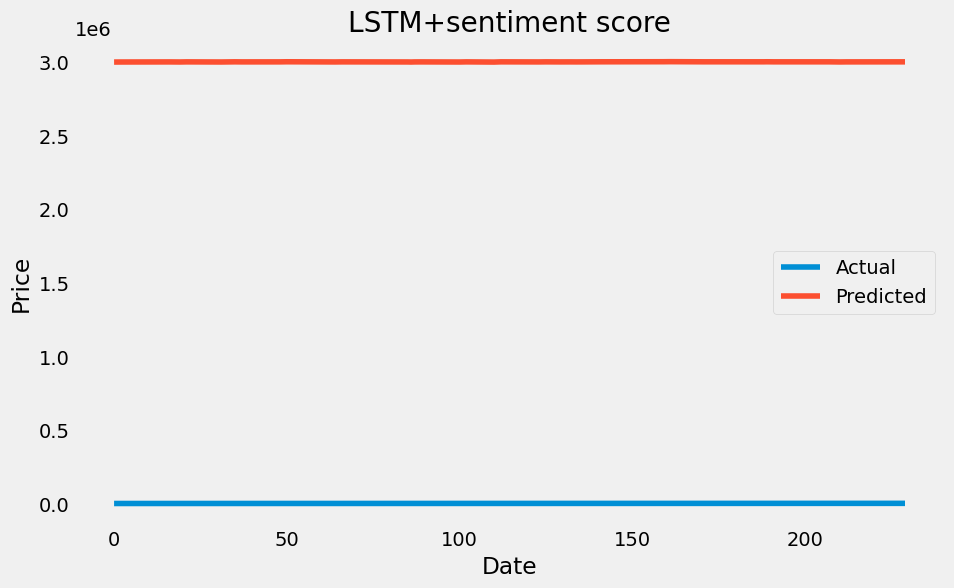

In [512]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(y_tata, label='Actual')
plt.plot(tata_predict, label='Predicted')

# Customize the chart
plt.title('LSTM+sentiment score')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
plt.grid()

# Display the chart
plt.show()

## Construct Dataframe

## Prediction

# CONCLUSION